In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np

In [ ]:
SEED = 0

In [39]:
adata = sc.read_h5ad(f"dyngen_bifurcating/adata_raw_{SEED}.h5ad")
adata

AnnData object with n_obs × n_vars = 1500 × 233
    obs: 'step_ix', 'simulation_i', 'sim_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
    obsm: 'dimred'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'

In [40]:
splicing_rate = adata.var["splicing_rate"].values.astype(np.float32)
decay_rate = adata.var["mrna_decay_rate"].values.astype(np.float32)
unspliced = adata.layers["counts_unspliced"].toarray().astype(np.float32)
spliced = adata.layers["counts_spliced"].toarray().astype(np.float32)
velocity = splicing_rate * unspliced - decay_rate * spliced

In [41]:
adata.layers["spliced"] = adata.layers.pop("counts_spliced")
adata.layers["unspliced"] = adata.layers.pop("counts_unspliced")
adata.layers["true_velocity"] = velocity

In [42]:
scv.pp.remove_duplicate_cells(adata)
adata.layers['raw_spliced'] = np.rint(adata.layers['spliced']).astype(int)
adata.layers['raw_unspliced'] = np.rint(adata.layers['unspliced']).astype(int)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
if adata.n_vars < 2000:
    sc.pp.highly_variable_genes(adata, n_top_genes=adata.n_vars, subset=True)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, random_state=SEED)
adata.obs['u_lib_size_raw'] = adata.layers['raw_unspliced'].sum(-1) 
adata.obs['s_lib_size_raw'] = adata.layers['raw_spliced'].sum(-1)

Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


d:\softwares\anaconda3\envs\scvelo_py39\lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
C:\Users\18307\AppData\Local\Temp\ipykernel_20080\2209009637.py:7: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
d:\softwares\anaconda3\envs\scvelo_py39\lib\site-packages\scvelo\preprocessing\moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


In [43]:
adata.write_h5ad(f"dyngen_bifurcating/adata_preprocessed_{SEED}.h5ad")

In [49]:
adata = sc.read_h5ad(f"dyngen_bifurcating/adata_preprocessed_0.h5ad")
adata

AnnData object with n_obs × n_vars = 1500 × 171
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'u_lib_size_raw', 's_lib_size_raw'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'umap'
    obsm: 'X_pca', 'X_umap', 'dimred'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'counts_protein', 'logcounts', 'raw_spliced', 'raw_unspliced', 'spliced', 'true_velocity', 'unspliced'
    obsp: 'connectivities', 'distances'

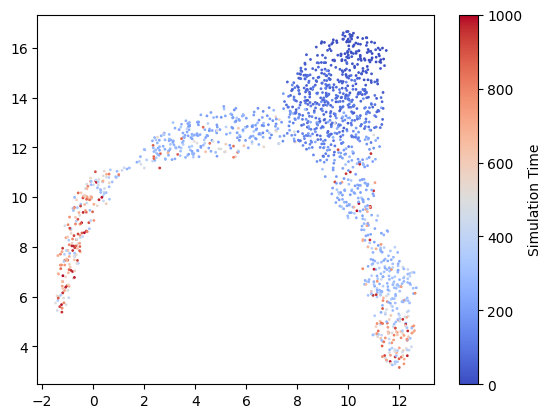

In [50]:
import matplotlib.pyplot as plt
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s=1, c=adata.obs['sim_time'], cmap='coolwarm')
plt.colorbar(label='Simulation Time')
plt.show()